### The flow and description

The flow
1) Getting the data from Job Board - HH
2) Cleaning the data
3) Storing them in a single dataframe
4) Uploading the dataframe into my Database
5) Running descriptive analysis
6) Tech stack extraction using OpenAi ChatGPT
7) Manually grouping extracted stack into categories
8) Applying out-of-box linear regression to assess 

In [ ]:
# checkpoint
df = pd.read_csv('/Users/igorrudakov/Desktop/last_download_hh.csv')
# df.head().T kjsnknflkvsnlvkl



In [74]:
import requests      # Для запросов по API
import json          # Для обработки полученных результатов
import time          # Для задержки между запросами
import os            # Для работы с файлами
import pandas as pd  # Для формирования датафрейма с результатами


In [4]:
!pip install psycopg2

     |████████████████████████████████| 384 kB 1.5 MB/s eta 0:00:01
Using legacy 'setup.py install' for psycopg2, since package 'wheel' is not installed.
    Running setup.py install for psycopg2 ... done
You should consider upgrading via the '/Users/igorrudakov/.pyenv/versions/3.10.0/envs/portfolio_fldr/bin/python3.10 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
DB_USER = 'iuser'
DB_PASSWORD = 'apple'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'local_igors_database'

# Create the connection string
connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Create the database engine
engine = create_engine(connection_string)

# Example dataframe
df = pd.DataFrame({
    'name': ['Alice', 'Bob', 'Charlie'],
    'age': [25, 30, 35]
})

# Store the dataframe in the database
df.to_sql('people', engine, if_exists='replace', index=False)

# Verify by reading back the data
df_from_db = pd.read_sql('SELECT * FROM people', engine)
print(df_from_db)

      name  age
0    Alice   25
1      Bob   30
2  Charlie   35


# Getting the data from Job Boards

In [83]:
# request to hh api

base_url = "http://opendata.trudvsem.ru/api/v1/vacancies"
params = {
        "region_code": '7700000000000',         # Ключевые слова в вакансии (OR между ними)
        'limit': 1000,                          # Кол-во вакансий на 1 странице
        'schedule':'Полный рабочий день',
        'employment':'Полная занятость'
    }
req = requests.get(base_url, params=params)
data = req.content.decode()
req.close()

In [85]:
rabota_ru =  pd.read_json( data )

## Head Hunter

### Getting HeadHunter professional roles

In [91]:
# request to hh api
def getProfRoles():
    req = requests.get('https://api.hh.ru/professional_roles')
    data = req.content.decode()
    req.close()
    return data

prof_roles =  pd.read_json( getProfRoles() )
prof_roles.head()

,categories
0,"{'id': '19', 'name': 'Автомобильный бизнес', '..."
1,"{'id': '5', 'name': 'Административный персонал..."
2,"{'id': '15', 'name': 'Безопасность', 'roles': ..."
3,"{'id': '26', 'name': 'Высший и средний менеджм..."
4,"{'id': '8', 'name': 'Добыча сырья', 'roles': [..."


In [92]:
# parsing the json and creating a dataframe

df_list = []

for category in prof_roles["categories"]:
    for role in category["roles"]:
        df_list.append({
            "category_id": category["id"],
            "category_name": category["name"],
            "role_id": role["id"],
            "role_name": role["name"],
            "accept_incomplete_resumes": role["accept_incomplete_resumes"],
            "is_default": role["is_default"]
        })


prof_roles_df = pd.DataFrame(df_list)


In [93]:
# renaming the columns
prof_roles_df = prof_roles_df.rename(columns={'category_id':'parent_profession_id',
                              'category_name':'parent_profession_name'
                              })
prof_roles_df.head()

,parent_profession_id,parent_profession_name,role_id,role_name,accept_incomplete_resumes,is_default
0,19,Автомобильный бизнес,4,Автомойщик,True,False
1,19,Автомобильный бизнес,5,"Автослесарь, автомеханик",True,False
2,19,Автомобильный бизнес,62,Мастер-приемщик,True,False
3,19,Автомобильный бизнес,70,"Менеджер по продажам, менеджер по работе с кли...",False,False
4,5,Административный персонал,8,Администратор,True,False


In [94]:
# leaving only clear roles (droping the parent ids)

prof_roles_df_short = prof_roles_df[['role_id','role_name']].drop_duplicates()
prof_roles_df_short.head()

,role_id,role_name
0,4,Автомойщик
1,5,"Автослесарь, автомеханик"
2,62,Мастер-приемщик
3,70,"Менеджер по продажам, менеджер по работе с кли..."
4,8,Администратор


In [97]:
prof_roles_df_short[prof_roles_df_short.role_id == '167']

,role_id,role_name
113,167,Методист


In [40]:
# saving to csv if needed
# prof_roles_df_short.to_csv('/Users/igorrudakov/Desktop/roles_ids.csv')

### Testing the API connection

In [8]:
# testing
base_url = "https://api.hh.ru/vacancies"
params = {
        "text": '',         # Ключевые слова в вакансии (OR между ними)
        'per_page': 10,      # Кол-во вакансий на 1 странице
        'area': 1,
        'professional_role': '10',
        'page':1
    }
daga = requests.get(base_url, params=params)



In [9]:
#  how the data looks like
daga.json()['items'][1]

{'id': '92784497',
 'premium': False,
 'name': 'Аналитик',
 'department': None,
 'has_test': False,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': None,
 'response_url': None,
 'sort_point_distance': None,
 'published_at': '2024-02-06T18:14:48+0300',
 'created_at': '2024-02-06T18:14:48+0300',
 'archived': False,
 'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=92784497',
 'branding': {'type': 'MAKEUP', 'tariff': None},
 'show_logo_in_search': True,
 'insider_interview': None,
 'url': 'https://api.hh.ru/vacancies/92784497?host=hh.ru',
 'alternate_url': 'https://hh.ru/vacancy/92784497',
 'relations': [],
 'employer': {'id': '2804795',
  'name': 'Мегамаркет',
  'url': 'https://api.hh.ru/employers/2804795',
  'alternate_url': 'https://hh.ru/employer/2804795',
  'logo_urls': {'240': 'https://hhcdn.ru/employer-logo/6303011.png',

### Getting the job data from HeadHunter

In [121]:
#  Defining the function

import requests
import pandas as pd



def get_headhunter_vacancies(keywords='', city_id='1', per_page=100, max_pages=1, date_from='2024-01-20', professional_role = ''):
    base_url = "https://api.hh.ru/vacancies"

    params = {
        "text": keywords,         # Ключевые слова в вакансии (OR между ними)
        'per_page': per_page,      # Кол-во вакансий на 1 странице
        'area': city_id,
        'date_from': date_from,
        # 'date_to': date_to,
        'professional_role': professional_role
    }

    data = {
        "vacancy_name": [],
        "department": [],
        "area_id": [],
        "area_name": [],
        "salary": [],
        "published_at": [],
        "created_at": [],
        "archived": [],
        "employer_id": [],  # Добавлено поле для employer_id
        "employer_name": [],  # Добавлено поле для employer_id
        "employer_link": [],  # Добавлено поле для employer_id
        "city": [],
        "schedule": [],
        "professional_roles": [],
        "working_time_modes": [],
        "experience": [],
        "employment": [],
        "alternate_url":[]
        # "description":[]
    }



    for page in range(max_pages):
        params['page'] = page
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            vacancies = response.json()['items']
            for vacancy in vacancies:
                data["vacancy_name"].append(vacancy.get('name', ''))
                data["department"].append(vacancy.get('department', ''))
                data["area_id"].append(vacancy.get('area', {}).get('id', ''))
                data["area_name"].append(vacancy.get('area', {}).get('name', ''))
                data["salary"].append(vacancy.get('salary', ''))
                data["published_at"].append(vacancy.get('published_at', ''))
                data["created_at"].append(vacancy.get('created_at', ''))
                data["archived"].append(vacancy.get('archived', ''))
                data["employer_id"].append(vacancy.get('employer', {}).get('id', ''))
                data["employer_name"].append(vacancy.get('employer', {}).get('name', ''))
                data["employer_link"].append(vacancy.get('employer', {}).get('alternate_url', ''))
                data["city"].append(city_id)
                data["schedule"].append(vacancy.get('schedule', {}).get('name', ''))
                data["professional_roles"].append(vacancy.get('professional_roles', ''))
                data["working_time_modes"].append(vacancy.get('working_time_modes', ''))
                data["experience"].append(vacancy.get('experience', {}).get('name', ''))
                data["employment"].append(vacancy.get('employment', {}).get('name', ''))
                data["alternate_url"].append(vacancy.get('alternate_url',''))
                # data["description"].append(vacancy.get('description',''))


        else:
            print(f"Error {response.status_code}: {response.text}")

    df = pd.DataFrame(data)
    return df


In [ ]:
get_headhunter_vacancies(keywords='', city_id='1', max_pages=100, professional_role=i, max_pages=1)

In [122]:

# Using the function
keywords = ""       # "аналитик|python-разработчик" 
city_id = '1'       # '1' - код для Москвы, можно добавить другие коды городов
max_pages = 20

final_df = pd.DataFrame()

for i in range(1, 5):
    professional_role = i
    try:
        vacancies_data = get_headhunter_vacancies(keywords=keywords, city_id=city_id, max_pages=max_pages, professional_role=i)
        final_df = pd.concat([final_df, vacancies_data], ignore_index=True)
    except:
        continue



In [123]:
print( final_df.vacancy_name.count() )
final_df.head(2)

2990


,vacancy_name,department,area_id,area_name,salary,published_at,created_at,archived,employer_id,employer_name,employer_link,city,schedule,professional_roles,working_time_modes,experience,employment,alternate_url
0,Менеджер по организации спецпроектов,None,1,Москва,"{'from': 72000, 'to': 90000, 'currency': 'RUR'...",2024-02-09T13:36:24+0300,2024-02-09T13:36:24+0300,False,2057439,Третьяковская галерея,https://hh.ru/employer/2057439,1,Полный день,"[{'id': '1', 'name': 'Event-менеджер'}]",[],От 1 года до 3 лет,Полная занятость,https://hh.ru/vacancy/92953060
1,Event-продюсер,"{'id': 'mailru-15478-vkontakt', 'name': 'VK, В...",1,Москва,None,2024-02-19T15:21:07+0300,2024-02-19T15:21:07+0300,False,15478,VK,https://hh.ru/employer/15478,1,Полный день,"[{'id': '1', 'name': 'Event-менеджер'}]",[],От 3 до 6 лет,Полная занятость,https://hh.ru/vacancy/93460100


#### Data cleaning

In [15]:
# create a copy of your dataframe to avoid requesting HH too often
vacancies_full = final_df

In [16]:
# reseting index
vacancies_full = vacancies_full.reset_index(drop=True)
vacancies_full.tail()

,vacancy_name,department,area_id,area_name,salary,published_at,created_at,archived,employer_id,employer_name,employer_link,city,schedule,professional_roles,working_time_modes,experience,employment,alternate_url,description
37980,Специалист транспортных решений (контейнерная ...,None,1,Москва,"{'from': 80000, 'to': 80000, 'currency': 'RUR'...",2024-02-08T13:00:39+0300,2024-02-08T13:00:39+0300,0.0,4971819,TEUSTAT,https://hh.ru/employer/4971819,1,Полный день,"[{'id': '172', 'name': 'Руководитель отдела ло...",[],От 1 года до 3 лет,Полная занятость,https://hh.ru/vacancy/91874990,
37981,Руководитель отдела сервиса и развития продаж ...,None,1,Москва,None,2024-02-08T15:21:36+0300,2024-02-08T15:21:36+0300,0.0,2493014,Транзит,https://hh.ru/employer/2493014,1,Полный день,"[{'id': '172', 'name': 'Руководитель отдела ло...",[],От 3 до 6 лет,Полная занятость,https://hh.ru/vacancy/88803361,
37982,Руководитель отдела сервиса и продаж рефрижера...,None,1,Москва,None,2024-02-08T10:38:53+0300,2024-02-08T10:38:53+0300,0.0,2493014,Транзит,https://hh.ru/employer/2493014,1,Полный день,"[{'id': '172', 'name': 'Руководитель отдела ло...",[],Нет опыта,Полная занятость,https://hh.ru/vacancy/90921014,
37983,Руководитель отдела сервиса и продаж рефрижера...,None,1,Москва,None,2024-02-08T14:37:51+0300,2024-02-08T14:37:51+0300,0.0,2493014,Транзит,https://hh.ru/employer/2493014,1,Полный день,"[{'id': '172', 'name': 'Руководитель отдела ло...",[],От 3 до 6 лет,Полная занятость,https://hh.ru/vacancy/91004387,
37984,Руководитель по развитию сервиса и продаж отде...,None,1,Москва,None,2024-02-06T08:33:03+0300,2024-02-06T08:33:03+0300,0.0,2493014,Транзит,https://hh.ru/employer/2493014,1,Полный день,"[{'id': '172', 'name': 'Руководитель отдела ло...",[],От 3 до 6 лет,Полная занятость,https://hh.ru/vacancy/86304851,


In [17]:

# Преобразование поля salary в отдельные колонки
df_salary = pd.json_normalize(vacancies_full['salary']).reset_index()
vacancies_full = pd.concat([vacancies_full, df_salary], axis=1, ignore_index=False)

# Преобразование поля professional_roles в отдельные колонки
df_roles = pd.json_normalize(vacancies_full['professional_roles'].explode())
vacancies_full = pd.concat([vacancies_full, df_roles], axis=1).rename(columns={'id':'role_id'})

# # # adding professional roles
vacancies_full = vacancies_full.merge(prof_roles_df,  
                                    how='left',
                                    left_on='role_id',
                                    right_on='role_id',
                                    copy=False,
                                    indicator = 'x_roles'
                                    )

vacancies_full['published_at'] = pd.to_datetime(vacancies_full.published_at)
vacancies_full['created_at']   = pd.to_datetime(vacancies_full.created_at)
# # 
vacancies_full['from'] = vacancies_full['from'].fillna(0).apply(lambda x: int(x) )
vacancies_full['to']   = vacancies_full['to'].fillna(0).apply(lambda x: int(x) )

vacancies_full = vacancies_full.drop(columns=['salary', 'professional_roles','working_time_modes', 'parent_profession_id', 'parent_profession_name',
                                                'archived','accept_incomplete_resumes','is_default','x_roles','department'])

vacancies_full = vacancies_full.drop_duplicates()


In [18]:
# creating a salary estimate (an average between from and to )
vacancies_full['salary_middle'] = vacancies_full.apply(lambda x: sum( [x['from'],x['to']]  ) / 2 if x['from'] > 0 and x['to'] > 0 else max(x['from'],x['to']) , axis=1)

In [19]:
# check for duplicates and columns that you don' need
vacancies_full.head().T

,0,1,2,3,4
vacancy_name,Менеджер по счастью,Ивент-менеджер / Организатор мероприятий,Event-менеджер в свадебное агентство,Менеджер по организации мероприятий,Менеджер по организации мероприятий
area_id,1,1,1,1,1
area_name,Москва,Москва,Москва,Москва,Москва
published_at,2024-02-02 12:03:11+03:00,2024-01-25 18:00:59+03:00,2024-01-20 13:29:47+03:00,2024-02-05 10:48:18+03:00,2024-01-22 18:16:25+03:00
created_at,2024-02-02 12:03:11+03:00,2024-01-25 18:00:59+03:00,2024-01-20 13:29:47+03:00,2024-02-05 10:48:18+03:00,2024-01-22 18:16:25+03:00
employer_id,1272486,10229371,5763554,52389,41903
employer_name,СберМаркет,EventGorod,Свадебное агентство Soulmates,"ЦУМ, ТД",Специальные системы и технологии
employer_link,https://hh.ru/employer/1272486,https://hh.ru/employer/10229371,https://hh.ru/employer/5763554,https://hh.ru/employer/52389,https://hh.ru/employer/41903
city,1,1,1,1,1
schedule,Полный день,Полный день,Полный день,Полный день,Полный день


In [20]:
vacancies_full.shape

(37985, 23)

### Descriptive statistics

In [27]:
# count of categories
vacancies_full.name.value_counts().to_frame().head(10)

,name
"Инженер-конструктор, инженер-проектировщик",2000
"Инженер ПТО, инженер-сметчик",2000
Аналитик,2000
Врач,1800
"Дизайнер, художник",1799
"SMM-менеджер, контент-менеджер",1466
Менеджер по персоналу,1363
"Слесарь, сантехник",1268
Технолог,1255
Кладовщик,1200


In [22]:
vacancies_full.describe(include='object')

,vacancy_name,area_id,area_name,employer_id,employer_name,employer_link,city,schedule,experience,employment,alternate_url,description,currency,gross,role_id,name,role_name
count,37985,37985,37985,37985,37985,37985,37985,37985,37985,37985,37985,37985,25665,25654,37985,37985,37985
unique,24760,1,1,14980,14879,14980,1,5,4,5,37984,1,3,2,81,81,81
top,Инженер ПТО,1,Москва,2180,Ozon,https://hh.ru/employer/2180,1,Полный день,От 1 года до 3 лет,Полная занятость,https://hh.ru/vacancy/91872543,,RUR,False,48,"Инженер-конструктор, инженер-проектировщик","Инженер-конструктор, инженер-проектировщик"
freq,389,37985,37985,312,312,312,37985,28616,18258,35847,2,37985,25552,18225,2000,2000,2000


In [116]:
vacancies_full.columns.values

array(['vacancy_name', 'area_id', 'area_name', 'published_at',
       'created_at', 'employer_id', 'employer_name', 'employer_link',
       'city', 'schedule', 'experience', 'employment', 'alternate_url',
       'description', 'index', 'from', 'to', 'currency', 'gross',
       'role_id', 'name', 'role_name', 'salary_middle'], dtype=object)

In [118]:
vacancies_full.description.describe()

count     37985
unique        1
top            
freq      37985
Name: description, dtype: object

In [113]:
vacancies_full.to_csv('/Users/igorrudakov/python_projects/portfolio_tests/labour_demand/datasets/vacancies_2024-02-20.csv', encoding='utf-8')

In [20]:
# table for analysis 1

import numpy as np 

vacancies_full[(vacancies_full['salary_middle'] != 0)].groupby(['role_name','experience', 'employment']).agg(
    mean=('salary_middle', 'mean'),
    std=('salary_middle', 'std'),
    min=('salary_middle', 'min'),
    perc_25=('salary_middle', lambda x: np.percentile(x, q=0.25)),
    median=('salary_middle', lambda x: np.percentile(x, q=0.5)),
    perc_75=('salary_middle', lambda x: np.percentile(x, q=0.75)),
    max=('salary_middle', 'max'),
    count=('salary_middle', 'count')
).reset_index().to_csv('/Users/igorrudakov/Desktop/job_data_aggr.csv', encoding='utf-8')



In [147]:
# if you need to save current file (checkpoint)
# vacancies_full.to_csv('/Users/igorrudakov/Desktop/last_download_hh.csv')

### Saving first ready to use table into the DataBase [in progress]

In [24]:
vacancies_full[vacancies_full.role_id == '10']

,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,city,schedule,...,description,index,from,to,currency,gross,role_id,name,role_name,salary_middle
14175,Ассистент отдела Retail,1,Москва,2024-01-22 09:48:55+03:00,2024-01-22 09:48:55+03:00,4173118,SuperStep,https://hh.ru/employer/4173118,1,Полный день,...,,5057,90000,0,RUR,False,10,Аналитик,Аналитик,90000.0
14179,Аналитик (удаленно),1,Москва,2024-01-22 12:07:01+03:00,2024-01-22 12:07:01+03:00,1419273,Работут,https://hh.ru/employer/1419273,1,Удаленная работа,...,,5058,120000,120000,RUR,False,10,Аналитик,Аналитик,120000.0
14183,Аналитик (Junior),1,Москва,2024-01-22 10:55:24+03:00,2024-01-22 10:55:24+03:00,2804795,Мегамаркет,https://hh.ru/employer/2804795,1,Удаленная работа,...,,5059,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0
14187,Младший аналитик (IT-компания),1,Москва,2024-01-22 11:46:35+03:00,2024-01-22 11:46:35+03:00,11632,DSM Group,https://hh.ru/employer/11632,1,Полный день,...,,5060,0,54500,RUR,False,10,Аналитик,Аналитик,54500.0
14191,Младший аналитик,1,Москва,2024-01-22 18:31:16+03:00,2024-01-22 18:31:16+03:00,11580,Фармстандарт,https://hh.ru/employer/11580,1,Полный день,...,,5061,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18607,Ведущий консультант-аналитик 1С (регламентиров...,1,Москва,2024-01-23 09:47:34+03:00,2024-01-23 09:47:34+03:00,142514,Рамакс Интернейшнл,https://hh.ru/employer/142514,1,Удаленная работа,...,,6165,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0
18611,Системный аналитик по 1С УНФ,1,Москва,2024-01-21 16:24:00+03:00,2024-01-21 16:24:00+03:00,1035394,"Красное & Белое, розничная сеть",https://hh.ru/employer/1035394,1,Полный день,...,,6166,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0
18615,Ведущий консультант-аналитик 1С (блок Аренда),1,Москва,2024-01-23 09:46:58+03:00,2024-01-23 09:46:58+03:00,142514,Рамакс Интернейшнл,https://hh.ru/employer/142514,1,Удаленная работа,...,,6167,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0
18619,Старший консультант-аналитик 1С (регламентиров...,1,Москва,2024-01-23 09:46:38+03:00,2024-01-23 09:46:38+03:00,142514,Рамакс Интернейшнл,https://hh.ru/employer/142514,1,Удаленная работа,...,,6168,0,0,NaN,NaN,10,Аналитик,Аналитик,0.0


### Getting vaccancy description from url

In [30]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep

browser = webdriver.Chrome()
browser.maximize_window()

In [24]:
# Defining the function
def get_hh_info(link_str):
    
    data = {
        'vacancy_description':[]
    }
    try:
        browser.get(link_str)        
        sleep(2)
        try:
            a = browser.find_element("xpath", '//div[@class="vacancy-description"]').text
        except:
            a = 'no_data'
        data['vacancy_description'].append(a)

        if len(browser.window_handles) > 1:
            browser.close()
        return data
    except:
        return 'no_data'

In [25]:
# getting only vacancies with salary 
# also choosing ONE SPECIFIC professional role - because it takes long to get the vacancy description data 
# you can do more - but just join them later
target_vaccancies = vacancies_full[ (vacancies_full['salary_middle'] > 0) & (vacancies_full['role_id'] == '10') ] # 10 for analysts
target_vaccancies.vacancy_name.count()

576

In [28]:
#  Launching the func
from tqdm import tqdm
tqdm.pandas(desc="Processing")
target_vaccancies['url_description'] = target_vaccancies.alternate_url.progress_apply(lambda x: get_hh_info(x) )

Processing: 100%|██████████| 576/576 [43:51<00:00,  4.57s/it]  
/var/folders/z8/hdkxtn_15wx2h07f409mskwm0000gn/T/ipykernel_17611/4240138661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_vaccancies['url_description'] = target_vaccancies.alternate_url.progress_apply(lambda x: get_hh_info(x) )


In [29]:
target_vaccancies[target_vaccancies.url_description == 'no_data']

,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,city,schedule,...,index,from,to,currency,gross,role_id,name,role_name,salary_middle,url_description
10997,Продуктовый аналитик / аналитик рынка (удаленно),1,Москва,2024-02-05 19:22:57+03:00,2024-02-05 19:22:57+03:00,10505147,Торговый Дом Мировой Шоппинг,https://hh.ru/employer/10505147,1,Удаленная работа,...,5814,110000,0,RUR,False,10,Аналитик,Аналитик,110000.0,no_data
11013,Аналитик IDM,1,Москва,2024-01-23 13:20:31+03:00,2024-01-23 13:20:31+03:00,906557,SberTech,https://hh.ru/employer/906557,1,Полный день,...,5818,173000,0,RUR,True,10,Аналитик,Аналитик,173000.0,no_data
11021,Маркетолог-аналитик,1,Москва,2024-02-08 09:41:17+03:00,2024-02-08 09:41:17+03:00,1326835,Ветпром,https://hh.ru/employer/1326835,1,Полный день,...,5820,85000,90000,RUR,False,10,Аналитик,Аналитик,87500.0,no_data
11045,Маркетолог-аналитик,1,Москва,2024-02-06 16:55:35+03:00,2024-02-06 16:55:35+03:00,2672593,Expotestdrive,https://hh.ru/employer/2672593,1,Полный день,...,5826,35000,50000,RUR,True,10,Аналитик,Аналитик,42500.0,no_data
11069,"Консультант/Аналитик 1С (БГУ, ЗКГУ, ЗУП)",1,Москва,2024-01-29 11:10:09+03:00,2024-01-29 11:10:09+03:00,2656,Первый Дом Консалтинга ЧТО ДЕЛАТЬ КОНСАЛТ,https://hh.ru/employer/2656,1,Полный день,...,5832,150000,0,RUR,True,10,Аналитик,Аналитик,150000.0,no_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14721,Аналитик 1С ЗУП,1,Москва,2024-02-07 09:51:56+03:00,2024-02-07 09:51:56+03:00,2325,World Class,https://hh.ru/employer/2325,1,Полный день,...,6745,0,220000,RUR,True,10,Аналитик,Аналитик,220000.0,no_data
14733,Аналитик,1,Москва,2024-01-22 17:46:03+03:00,2024-01-22 17:46:03+03:00,5466803,Балуева Елена Андреевна,https://hh.ru/employer/5466803,1,Полный день,...,6748,0,70000,RUR,False,10,Аналитик,Аналитик,70000.0,no_data
14765,Аналитик 1С,1,Москва,2024-02-07 16:43:17+03:00,2024-02-07 16:43:17+03:00,103816,Россети Московский регион,https://hh.ru/employer/103816,1,Полный день,...,6756,152000,200000,RUR,False,10,Аналитик,Аналитик,176000.0,no_data
14785,Аналитик отдела продаж,1,Москва,2024-02-08 15:10:55+03:00,2024-02-08 15:10:55+03:00,2569687,ПРОФИЛАБТЕСТ,https://hh.ru/employer/2569687,1,Полный день,...,6761,0,100000,RUR,True,10,Аналитик,Аналитик,100000.0,no_data


In [70]:
# target_vaccancies['description_flag'] = target_vaccancies.url_description.apply(lambda x: 1 if x != 'no_data' else 0)
target_vaccancies['url_description'] = target_vaccancies['url_description'].apply(lambda x:  x['vacancy_description'][0] ) 


In [317]:
# vacancies_w_salary.to_csv('/Users/igorrudakov/Desktop/vacancies_w_salary.csv', encoding='utf-8', index=True)

In [31]:
target_vaccancies.head()

,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,city,schedule,...,index,from,to,currency,gross,role_id,name,role_name,salary_middle,url_description
6861,Специалист по Excel (подработка),1,Москва,2024-01-25 15:34:39+03:00,2024-01-25 15:34:39+03:00,3804435,Lemon Media,https://hh.ru/employer/3804435,1,Удаленная работа,...,4780,10000,10000,RUR,False,10,Аналитик,Аналитик,10000.0,{'vacancy_description': ['Привет! Компания Lem...
6865,Аналитик,1,Москва,2024-02-08 09:22:50+03:00,2024-02-08 09:22:50+03:00,869045,Московский метрополитен,https://hh.ru/employer/869045,1,Полный день,...,4781,100000,150000,RUR,False,10,Аналитик,Аналитик,125000.0,{'vacancy_description': ['ОБЯЗАННОСТИ Взаимоде...
6873,Младший аналитик,1,Москва,2024-02-05 16:10:09+03:00,2024-02-05 16:10:09+03:00,723254,PanClub,https://hh.ru/employer/723254,1,Удаленная работа,...,4783,60000,0,RUR,True,10,Аналитик,Аналитик,60000.0,{'vacancy_description': ['Открыта вакансия Мла...
6877,Аналитик УДАЛЕННО!,1,Москва,2024-02-01 15:12:10+03:00,2024-02-01 15:12:10+03:00,5205,МАЙ,https://hh.ru/employer/5205,1,Удаленная работа,...,4784,97000,97000,RUR,True,10,Аналитик,Аналитик,97000.0,{'vacancy_description': ['Присоединяйтесь к на...
6881,"Аналитик данных (Excel, SQL)",1,Москва,2024-02-06 20:15:12+03:00,2024-02-06 20:15:12+03:00,127256,СИНЕРГИЯ,https://hh.ru/employer/127256,1,Полный день,...,4785,60000,0,RUR,False,10,Аналитик,Аналитик,60000.0,{'vacancy_description': ['Корпорация «Синергия...


In [36]:
target_vaccancies.vacancy_name.count()

576

### Getting company's industry from url

In [ ]:
# Defining the function
# import requests

def get_company_industry(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses

        data = response.json()
        industries = data.get('industries', [])

        if industries:
            return industries[0].get('name', 'no_data')
        else:
            return 'no_data'

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return 'no_data'

# url = 'https://api.hh.ru/employers/11632' # link empoyer


# Example usage
# url = 'https://api.hh.ru/employers/11632'
# industry = get_company_industry(url)
# print(industry)

### Aggregates: Getting counts of vacancies and professional roles

In [102]:

base_url = "https://api.hh.ru/vacancies"

job_counts = []
professional_role_id = []


for prof_role in range(1,175):
    params = {
            'area': 1,
            'professional_role': prof_role,
            'per_page': 1
        }
    resp = requests.get(base_url, params=params)
    if resp.status_code == 200:
        response_data = resp.json()
        found_vacancies = response_data.get('found', 0)

        professional_role_id.append(prof_role)
        job_counts.append(found_vacancies)
    else:
        continue



    data = {
    # 'area':113, #russia
    'area':1,   #rmoscow
    'professional_role_id':professional_role_id,
    'job_counts':job_counts
}

moscow_count_df = pd.DataFrame(data)
# russia_count_df = pd.DataFrame(data)


In [103]:
moscow_count_df[ moscow_count_df.professional_role_id == 1 ] 

,area,professional_role_id,job_counts
0,1,1,493


In [104]:
# russia_count_df.to_csv('/Users/igorrudakov/Desktop/jobcounts_russia.csv', encoding='utf-8')
moscow_count_df.to_csv('/Users/igorrudakov/Desktop/jobcounts_moscow.csv', encoding='utf-8')


## Extracting skills with Chat GPT

### defining the function

In [37]:
        prompt = '''
        Extract the technology stack items mentioned in the job description. Technology indicates that you need software to be able to do it.
        (example: 'Excel;SQL;1С - DO NOT INCLUDE EXAMPLE IN THE OUTPUT!). Exclude soft skills. Use ';' as a delimiter between elements you extract. 
        Ensure concise output within 150 tokens. Return a text containing the skills.                    '''
prompt = prompt.strip().replace('\n','').replace('            ','')
prompt
            

"Extract the technology stack items mentioned in the job description. Technology indicates that you need software to be able to do it.(example: 'Excel;SQL;1С - DO NOT INCLUDE EXAMPLE IN THE OUTPUT!). Exclude soft skills. Use ';' as a delimiter between elements you extract. Ensure concise output within 150 tokens. Return a text containing the skills."

In [79]:
import pandas as pd
import json
from dotenv import load_dotenv
from openai import OpenAI
import os
from IPython.display import Markdown



# Set your OpenAI GPT-3 API key
load_dotenv()
client = OpenAI()

api_key=os.environ.get("OPENAI_API_KEY"),
OpenAI.api_key = api_key

def extract_key_skills_requirements(vacancy_description, prompt):
    try:
        # Define the prompt for ChatGPT
        prompt = prompt

        # Call the OpenAI API
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[ {"role": "user","content": f'{prompt}. Vacancy description is: {vacancy_description}.'} ],
            max_tokens=150, 
            temperature=0.7
        )

        generated_text = response.choices[0].message.content
        return generated_text


    except Exception as e:
        return f"Error: {str(e)}"




#### Checking the Function output

In [86]:
test_desctiption = test_df['vacancy_description'][1].strip().replace('\n', '. ')
a = extract_key_skills_requirements( test_desctiption , prompt)
Markdown(a)

Excel; SQL; Metabase; SaaS; MS SQL; Power BI; Qlik-Sense; Анализ данных; Анализ бизнес показателей

In [274]:
Markdown( test_df['vacancy_description'][1].strip().replace('\n', '. ')[:] )

Teachbase — Teachbase — экосистема образовательных решений. Наш главный продукт — платформа для запуска обучения. Уже более 10 лет эффективно решаем задачи: от онбординга и развития сотрудников до запуска масштабных образовательных проектов. Наши клиенты — 400+ компаний. Среди них — Домодедово, банк «Точка», Газпром нефть, Гемотест, Skyeng, Яндекс, MANTERA, World Class, Промсвязьбанк, Магнит Доставка, LVMH.. Teachbase — это минимум рутины и люди, которым не все равно на результат работы. Вместе с крутой командой профессионалов ты будешь участвовать в развитии продукта и реализовать разноплановые кастомные проекты — с нами точно не будет скучно!. Проектов становится все больше, поэтому мы расширяем команду.. Задачи на позиции:. Аналитическая деятельность на стыке продаж/маркетинга и продукта;. Разработка автоматизированной отчётности, дашбордов. Автоматизация текущих отчетностей отделов продаж/маркетинга и продукта;. Анализ показателей продукта и продаж, выводы из собранных данных. Как пример - собрали данные в Excel по продажам по направлениям продаж, собрали продуктовые метрики, далее собрали в Excel дашборд или в специальной программе, сделали выводы о том, какое направление продаж дало нам больше по сумме за период и с чем это связано, откуда пришли лиды и какие запросы есть на продукт и на его развитие;. Формирование отчётности по запросу руководителя.. Наши пожелания к кандидату:. Excel продвинутый уровень.. знание SQL ( опыт работы в Metabase является плюсом).. Опыт работы в аналитике в сфере IT B2B SaaS от 1 года.. Приветствуется опыт работы в продажах/маркетинге, продукте.. Что мы предлагаем:. Сложные и интересные задачи, с которыми получишь профессиональный рост и безусловно удовольствие от процесса;. Локация — место, где будешь комфортно и продуктивно работать (удаленка), или офис в Москве (м. Парк культуры);. График: пятидневка с 10 до 19, можно сдвинуть на полчаса-час в удобную сторону.. Ключевые навыки. SaaS. MS SQL. Power BI. Qlik-Sense. Excel. Metabase. Анализ данных. Анализ бизнес показателей.

In [125]:
text = '''
00. офисов компании. по России и миру. >6000. сотрудников. в компании. >300000. успешно внедренных. проектов. Вакансия открыта в один из проектных департаментов 
 ТЫ БУДЕШЬ ЗА
      НИМАТЬСЯ:. Интенсивным обучением 1С и предметным областям (фин.учету);. Обследованием и описанием бизнес-процессов заказчика;. 
      Интервьюированием ключевых пользователей, проведением совещаний с ведущими специалистами заказчика;. Описанием бизнес-процессов заказчика;. 
      Написанием проектной документации: отчетов об обследовании, инструкций, проектных решений;. Постановкой задач разработчикам по задачам проекта, 
      тестированием и приемкой результата;. Сдачей результатов представителям заказчика;. Консультированием и обучением специалистов заказчика.. . 
      #аналитик1С #вакансия1С #ПервыйБитофисСпортивная. Ключевые навыки. Аналитик 1С. Финансовый учет. Бухгалтерский учет. Проект
'''

extract_key_skills_requirements(text.strip().replace('\n',''), prompt)

'1C; финансовый учет; бухгалтерский учет; проект'

### Preparing the dataset

In [42]:
target_vaccancies[ (target_vaccancies.schedule == 'Полный день')&( target_vaccancies.employment == 'Полная занятость')].head()

,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,city,schedule,...,index,from,to,currency,gross,role_id,name,role_name,salary_middle,url_description
6865,Аналитик,1,Москва,2024-02-08 09:22:50+03:00,2024-02-08 09:22:50+03:00,869045,Московский метрополитен,https://hh.ru/employer/869045,1,Полный день,...,4781,100000,150000,RUR,False,10,Аналитик,Аналитик,125000.0,{'vacancy_description': ['ОБЯЗАННОСТИ Взаимоде...
6881,"Аналитик данных (Excel, SQL)",1,Москва,2024-02-06 20:15:12+03:00,2024-02-06 20:15:12+03:00,127256,СИНЕРГИЯ,https://hh.ru/employer/127256,1,Полный день,...,4785,60000,0,RUR,False,10,Аналитик,Аналитик,60000.0,{'vacancy_description': ['Корпорация «Синергия...
6909,"Аналитик ГБУ ""МосСпортОбъект""",1,Москва,2024-02-06 11:38:09+03:00,2024-02-06 11:38:09+03:00,2642917,ГБУ МосСпортОбъект,https://hh.ru/employer/2642917,1,Полный день,...,4792,108850,0,RUR,True,10,Аналитик,Аналитик,108850.0,{'vacancy_description': ['Обязанности: Участво...
6913,Главный специалист-аналитик в отдел мониторинг...,1,Москва,2024-01-26 11:44:25+03:00,2024-01-26 11:44:25+03:00,3390296,ГБУ МФЦ города Москвы Мои документы,https://hh.ru/employer/3390296,1,Полный день,...,4793,0,108450,RUR,True,10,Аналитик,Аналитик,108450.0,{'vacancy_description': ['no_data']}
6925,Специалист сектора мониторинга лекарственного ...,1,Москва,2024-02-06 12:09:42+03:00,2024-02-06 12:09:42+03:00,6042525,ГБУ города Москвы Центр мониторинга и развития...,https://hh.ru/employer/6042525,1,Полный день,...,4796,115000,0,RUR,True,10,Аналитик,Аналитик,115000.0,{'vacancy_description': ['Обязанности: Работа ...


In [70]:
import ast

# Assuming df_for_gpt is your DataFrame
df_for_gpt.url_description.['vacancy_description']


0      {'vacancy_description': ['ОБЯЗАННОСТИ
Взаимоде...
1      {'vacancy_description': ['Корпорация «Синергия...
2      {'vacancy_description': ['Обязанности:
Участво...
3                   {'vacancy_description': ['no_data']}
4      {'vacancy_description': ['Обязанности:
Работа ...
                             ...                        
414                                              no_data
415                                              no_data
416                                              no_data
417                                              no_data
418                                              no_data
Name: url_description, Length: 419, dtype: object

In [76]:
# Only taking full time jobs 

df_for_gpt = target_vaccancies[ ( target_vaccancies.schedule == 'Полный день')&\
                                ( target_vaccancies.employment == 'Полная занятость')&\
                                ( target_vaccancies.url_description != 'no_data')   
                                ].reset_index(drop=True)
 
# removing spaces and tabs
df_for_gpt['vacancy_description'] = df_for_gpt.url_description.apply(lambda x: x['vacancy_description'][0].strip().replace('\n', '. '))

# # # removing last technical lines
df_for_gpt['vacancy_description'] = df_for_gpt.vacancy_description.apply(lambda x: x[0: x.find('Задайте вопрос работодателю') ]  )

# # # limiting input to 3000 words 
df_for_gpt['vacancy_description'] = df_for_gpt.vacancy_description.apply(lambda x: x[:3000] )

# # # description len
df_for_gpt['description_len'] = df_for_gpt.vacancy_description.apply(lambda x: len(x) )


In [77]:
df_for_gpt.vacancy_name.count()

265

In [78]:
df_for_gpt[df_for_gpt.description_len == df_for_gpt.description_len.max()].vacancy_name.count()

27

### Testing 

In [80]:
test_df = df_for_gpt[['vacancy_name', 'vacancy_description','salary_middle']].sample(30).reset_index(drop=True)

In [81]:
test_df['output'] = test_df['vacancy_description'].progress_apply(lambda x: extract_key_skills_requirements(x.strip().replace('\n',''), prompt) )

Processing: 100%|██████████| 30/30 [02:54<00:00,  5.82s/it]


In [83]:
test_df.output[0]

"Error: Error code: 500 - {'error': {'message': 'Internal server error', 'type': 'auth_subrequest_error', 'param': None, 'code': 'internal_error'}}"

In [82]:
test_df.head()

,vacancy_name,vacancy_description,salary_middle,output
0,Стажер (Data analyst),МТС — это мультисервисная цифровая экосистема....,40000.0,Error: Error code: 500 - {'error': {'message':...
1,Аналитик данных/бизнес аналитик,Teachbase — Teachbase — экосистема образовател...,95000.0,Error: Error code: 500 - {'error': {'message':...
2,Продуктовый аналитик,Всем привет! На связи команда SOAK!. Кто мы?. ...,150000.0,Error: Error code: 500 - {'error': {'message':...
3,Бизнес-аналитик / Системный аналитик - BPMSoft,Компания Trace состоит из двух бизнес юнитов -...,190000.0,Error: Error code: 500 - {'error': {'message':...
4,"Аналитик ГБУ ""МосСпортОбъект""",Обязанности:. Участвовать в составлении докуме...,108850.0,Error: Error code: 500 - {'error': {'message':...


In [128]:
test_df.to_csv('/Users/igorrudakov/Desktop/test_skills_gpt.csv')

In [718]:
test_skills = []

for i in test_df['output']:
    for sk in i.split(';'):
        test_skills.append(sk.replace('\n',''))

In [719]:
test_skills

['Excel: Office_programs',
 'Power BI: Visualization',
 'Tableau: Visualization',
 'Google Analytics: Web_analytics',
 'Yandex Metrika: Web_analytics',
 'Google Tag Manager: Integration_tools',
 'JS: Programming_language',
 'Python: Programming_language',
 'SQL: Programming_language',
 'BigQuery: Data_storage_tools',
 'ClickHouse: Data_storage_tools',
 'Maria DB: Data_storage_tools',
 'Redash: Visualization',
 'Metabase: Visualization',
 'Appsflyer: Mobile_app_analytics',
 'MyTracker: Mobile_app_analytics',
 'Adjust: Mobile_app_analytics',
 'AppMetrica: Mobile_app_analytics',
 'git: Version_control_system',
 'numpy: Data_analysis_library',
 'pandas: Data_analysis_library',
 'scikit-learn: Data_analysis_library',
 'SQLAlchemy',
 'MS Office:Office_programs',
 ' internet:surfing',
 ' analytical_research:analytical_research',
 ' databases:database_management',
 ' internet_search:information_search',
 ' analytical_thinking:analytical_thinking',
 ' market_monitoring:market_monitoring',
 ' do

In [721]:
pd.Series(test_skills).to_csv('/Users/igorrudakov/Desktop/test_skills_gpt.csv')

### Scalling to all data

In [134]:
df_for_gpt['gpt_output_skills'] = df_for_gpt['vacancy_description'].progress_apply(lambda x: extract_key_skills_requirements(x.strip().replace('\n',''), prompt) )

Processing: 100%|██████████| 228/228 [08:04<00:00,  2.12s/it]


In [487]:
df_for_gpt.to_csv('/Users/igorrudakov/python_projects/portfolio_tests/labour_demand/datasets/last_output_gpt_feb7.csv')

In [156]:
# df_for_gpt = yy.reset_index(drop=True) 
df_for_gpt = pd.read_csv('/Users/igorrudakov/python_projects/portfolio_tests/labour_demand/datasets/last_output_gpt_feb7.csv')

In [143]:
# getting skills for manual mapping and categorization
gpt_skills = []

for i in df_for_gpt['gpt_output_skills']:
    for sk in i.split(';'):
        gpt_skills.append(sk)


# SET DESTINATION!
# pd.Series(gpt_skills).drop_duplicates().to_csv('/Users/igorrudakov/Desktop/skills_from_gpt.csv', sep='&')

In [158]:
# putting skills back after manual categorization
maped_skills = pd.read_csv('/Users/igorrudakov/Desktop/mapped_skills.csv')
maped_skills.head(2)

,skill_string,stack_clean,category
0,диаграммы потоков данных,business_architecture,business_architecture
1,инструменты моделирования бизнес-процессов.,business_architecture,business_architecture


In [157]:
df_for_gpt.head()

,Unnamed: 0.1,Unnamed: 0,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,...,currency,gross,role_id,name,role_name,salary_middle,url_description,vacancy_description,description_len,gpt_output_skills
0,0,14175,Ассистент отдела Retail,1,Москва,2024-01-22 09:48:55+03:00,2024-01-22 09:48:55+03:00,4173118,SuperStep,https://hh.ru/employer/4173118,...,RUR,False,10,Аналитик,Аналитик,90000.0,Команда SuperStep ждёт именно тебя!\nSuperStep...,Команда SuperStep ждёт именно тебя!\nSuperStep...,1692,"1с; Excel; MS Office (Word, Exсel, Outlook, Po..."
1,1,14187,Младший аналитик (IT-компания),1,Москва,2024-01-22 11:46:35+03:00,2024-01-22 11:46:35+03:00,11632,DSM Group,https://hh.ru/employer/11632,...,RUR,False,10,Аналитик,Аналитик,54500.0,"""DSM Group"" – признанный эксперт и надёжный па...","""DSM Group"" – признанный эксперт и надёжный па...",2500,R;Excel;SQL;VBA;Python;PL-SQL;Oracle;MS SQL
2,2,14195,Специалист по обработке информации,1,Москва,2024-01-22 11:44:21+03:00,2024-01-22 11:44:21+03:00,53797,"ЭФКО, Управляющая компания",https://hh.ru/employer/53797,...,RUR,True,10,Аналитик,Аналитик,105000.0,Начни свой карьерный путь\nв компании «ЭФКО»\n...,Начни свой карьерный путь\nв компании «ЭФКО»\n...,948,MS Excel
3,3,14231,Аналитик (Правительство Москвы),1,Москва,2024-01-23 09:35:05+03:00,2024-01-23 09:35:05+03:00,4005237,ГКУ города Москвы Московский центр развития со...,https://hh.ru/employer/4005237,...,RUR,False,10,Аналитик,Аналитик,70000.0,"Обязанности:\nПоиск, структурирование и анализ...","Обязанности:\nПоиск, структурирование и анализ...",1390,Excel; Power Point; VBA; power query; формулы ...
4,4,14243,Аналитик товарного ассортимента,1,Москва,2024-01-22 18:38:51+03:00,2024-01-22 18:38:51+03:00,4747616,Абрико,https://hh.ru/employer/4747616,...,RUR,True,10,Аналитик,Аналитик,200000.0,Обязанности:\nСоставление товарной матрицы ( п...,Обязанности:\nСоставление товарной матрицы ( п...,2051,1С: Розница;1С: Управление Торговлей;1С: Предп...


,skill_string,category
0,диаграммы потоков данных,business_architecture
1,инструменты моделирования бизнес-процессов.,business_architecture
2,интеграционные потоки,business_architecture
3,интеграция с сторонними сервисами и приложениями,business_architecture
4,моделирование бизнес процессов,business_architecture
...,...,...
1025,Powerpoint,visualization
1026,presentations,visualization
1027,QlikView,visualization
1028,Redash,visualization


In [173]:
# transforming skill table into dictionary

df = maped_skills[['skill_string','category']] 

# Initialize an empty dictionary
category_skill_dict = {}

# Iterate over each row of the DataFrame
for index, row in df.iterrows():
    skill = row['skill_string']
    category = row['category']
    
    # If category already exists in the dictionary, append the skill to its list
    if category in category_skill_dict:
        category_skill_dict[category].append(skill)
    # Otherwise, create a new key-value pair with the category and a list containing the skill
    else:
        category_skill_dict[category] = [skill]



In [179]:
skill_row = {}
for item in set( stack_expanded_dict['category'] ):
    skill_row.setdefault(item, [])
skill_row

{'language': [],
 'domain_knowledge': [],
 'other': [],
 'business_architecture': [],
 'office_program': [],
 'special_software': [],
 'coding': [],
 'visualization': []}

In [180]:
# copy the existing df for hedging mistakes
df_for_gpt_copy = df_for_gpt

# Block 1: creating a dictionary of skill_category : [skills...]
# skills_2 = {}

# for item in set( stack_expanded_dict.values() ):
#     skills_2.setdefault(item, [])

# for pair in stack_expanded_dict.items():
#     skills_2[ pair[1] ].append( pair[0] )


# Block 2: Applying dictionary above to tag vacancies on whether or not they have a category skill
skill_row = {}
for item in set( stack_expanded_dict['category'] ):
    skill_row.setdefault(item, [])

def search_in_list(text_w_skills ):
    set_o_skills = set( [ el.strip() for el in text_w_skills.split(';') ] )
    
    for skill in category_skill_dict.keys():
        if len( set_o_skills.intersection( set( category_skill_dict[skill] ) ) ) > 0:
            skill_row[skill].append(1)
        else:
            skill_row[skill].append(0)


# Applying the function to the copy df
for i in df_for_gpt_copy['gpt_output_skills']:
    search_in_list(i)

In [181]:
# check if everything works fine
df_for_gpt_copy = pd.concat( [ df_for_gpt_copy.reset_index(drop=True) , pd.DataFrame(skill_row) ], axis=1 )
df_for_gpt_copy.iloc[:,25:].isnull().sum()

url_description          0
vacancy_description      0
description_len          0
gpt_output_skills        0
language                 0
domain_knowledge         0
other                    0
business_architecture    0
office_program           0
special_software         0
coding                   0
visualization            0
dtype: int64

In [182]:
exp_cats = {'От 1 года до 3 лет': 2, 'Нет опыта':1 , 'От 3 до 6 лет':3, 'Более 6 лет':4}
df_for_gpt_copy['experience_cat'] = df_for_gpt_copy.experience.apply(lambda x: exp_cats.get(x)  )

In [183]:
df_for_gpt_copy.iloc[:,25:].count()

url_description          228
vacancy_description      228
description_len          228
gpt_output_skills        228
language                 228
domain_knowledge         228
other                    228
business_architecture    228
office_program           228
special_software         228
coding                   228
visualization            228
experience_cat           228
dtype: int64

In [218]:
df_for_gpt_copy[
    [
        'vacancy_name','url_description','gpt_output_skills', 'language', 'domain_knowledge', 'other',
       'business_architecture', 'office_program', 'special_software', 'coding',
       'visualization', 'experience_cat'
    ]
].head(3)

,vacancy_name,url_description,gpt_output_skills,language,domain_knowledge,other,business_architecture,office_program,special_software,coding,visualization,experience_cat
0,Ассистент отдела Retail,Команда SuperStep ждёт именно тебя!\nSuperStep...,"1с; Excel; MS Office (Word, Exсel, Outlook, Po...",0,0,0,0,1,1,0,0,2
1,Младший аналитик (IT-компания),"""DSM Group"" – признанный эксперт и надёжный па...",R;Excel;SQL;VBA;Python;PL-SQL;Oracle;MS SQL,0,0,0,0,1,0,1,0,1
2,Специалист по обработке информации,Начни свой карьерный путь\nв компании «ЭФКО»\n...,MS Excel,0,0,0,0,1,0,0,0,2


In [204]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Sample data
X = df_for_gpt_copy[ ['language', 'domain_knowledge','other', 'business_architecture', 'office_program', 'special_software',
       'coding', 'visualization', 'experience_cat'] ] 
y = df_for_gpt_copy['salary_middle']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [211]:
# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# # # Add intercept to the DataFrame
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]})
coef_df = pd.concat([intercept_row, coef_df])

coef_df.round(0).astype({'Coefficient':int})

,Feature,Coefficient
0,Intercept,40274
0,language,-5161
1,domain_knowledge,4894
2,other,-8269
3,business_architecture,38903
4,office_program,-37076
5,special_software,2322
6,coding,10146
7,visualization,-7037
8,experience_cat,50735


In [199]:
import statsmodels.api as sm

# Sample data
X = df_for_gpt_copy[['language', 'domain_knowledge', 'other', 'business_architecture', 'office_program', 'special_software', 'coding', 'visualization', 'experience_cat']]
y = df_for_gpt_copy['salary_middle']

# Add constant term to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Create and fit the model
model = sm.OLS(y, X).fit()

# Print model summary
model.summary()




                            OLS Regression Results                            
Dep. Variable:          salary_middle   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     23.85
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           3.98e-28
Time:                        19:48:16   Log-Likelihood:                -2787.6
No. Observations:                 228   AIC:                             5595.
Df Residuals:                     218   BIC:                             5630.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.027e+

In [226]:
import statsmodels.api as sm

# Sample data
X = df_for_gpt_copy[[  'business_architecture', 'office_program', 'experience_cat']]
y = df_for_gpt_copy['salary_middle']

# Add constant term to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Create and fit the model
model = sm.OLS(y, X).fit()

# Print model summary
print( model.summary() )

                            OLS Regression Results                            
Dep. Variable:          salary_middle   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     70.98
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           2.65e-32
Time:                        23:43:39   Log-Likelihood:                -2789.6
No. Observations:                 228   AIC:                             5587.
Df Residuals:                     224   BIC:                             5601.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.623e+

In [233]:
model.params.to_frame().astype(int).rename(columns={0:'coefficient'})

,coefficient
const,36229
business_architecture,40911
office_program,-34907
experience_cat,51102


In [234]:
df_for_gpt_copy.head().T

,0,1,2,3,4
Unnamed: 0.1,0,1,2,3,4
Unnamed: 0,14175,14187,14195,14231,14243
vacancy_name,Ассистент отдела Retail,Младший аналитик (IT-компания),Специалист по обработке информации,Аналитик (Правительство Москвы),Аналитик товарного ассортимента
area_id,1,1,1,1,1
area_name,Москва,Москва,Москва,Москва,Москва
published_at,2024-01-22 09:48:55+03:00,2024-01-22 11:46:35+03:00,2024-01-22 11:44:21+03:00,2024-01-23 09:35:05+03:00,2024-01-22 18:38:51+03:00
created_at,2024-01-22 09:48:55+03:00,2024-01-22 11:46:35+03:00,2024-01-22 11:44:21+03:00,2024-01-23 09:35:05+03:00,2024-01-22 18:38:51+03:00
employer_id,4173118,11632,53797,4005237,4747616
employer_name,SuperStep,DSM Group,"ЭФКО, Управляющая компания",ГКУ города Москвы Московский центр развития со...,Абрико
employer_link,https://hh.ru/employer/4173118,https://hh.ru/employer/11632,https://hh.ru/employer/53797,https://hh.ru/employer/4005237,https://hh.ru/employer/4747616


In [465]:
Markdown( df_for_gpt_copy[(df_for_gpt_copy['gpt_output_skills'].str.contains('MPstats') == 1 )].vacancy_description.values[0] )

Нашей компании в области продаж на маркетплейсах, а именно Wildberries (Вайлдберриз) необходим менеджер, специалист, имеющий опыт работы в этой области.
У нас большая молодёжная команда: дизайнеры, контент-менеджеры и др. У всех есть желание развиваться и нацеленность на результат, будем рады видеть у себя в команде такого же единомышленника.
Обязанности:
работа с маркетплейсами Wildberries(Вайлдберриз);
продвижение продукции, согласование действующих акций;
подготовка предложений по корректировке цен;
анализ ниши товаров;
использование различных инструментов для продвижения товара;
вывод товаров в ТОП;
мониторинг изменений в работе маркетплейсов;
подготовка прочей аналитической информации.
Требования:
наличие опыта работы с маркетплейсами на должности менеджера/аналитика;
аналитический склад ума;
уверенный пользователь Excel, Google-таблиц, MPstats.
Условия:
график работы 5/2, 09.00 -18.00 (работа в офисе);
оформление по ТК РФ;
оплачиваемые отпуска, больничные;
чай/кофе, комфортный офис премиум класса;
уровень зарплаты обсуждается индивидуально с каждым кандидатом;
дружный коллектив, лояльное руководство.
Адрес: Москва, Дмитровское шоссе, 71Б, Бизнес-центр "7ONE" у метро "Верхние Лихоборы", м./мцк Окружная
Задайте вопрос работодателю
Он получит его с откликом на вакансию
Где располагается место работы?Какой график работы?Вакансия открыта?Какая оплата труда?Как с вами связаться?Другой вопрос
Адрес
Москва, Дмитровское шоссе, 71Б
© Яндекс Условия использования
Показать на большой карте

In [466]:
df_for_gpt_copy[(df_for_gpt_copy['gpt_output_skills'].str.contains('MPstats') == 1 )].T

,35
Unnamed: 0,14663
vacancy_name,Менеджер маркетплейсов Wildberries (Вайлдберриз)
area_id,1
area_name,Москва
published_at,2024-01-23 16:47:08+03:00
created_at,2024-01-23 16:47:08+03:00
employer_id,9529825
employer_name,ВВТ Вектор
employer_link,https://hh.ru/employer/9529825
city,1


In [457]:
Markdown( df_for_gpt_copy[(df_for_gpt_copy['alternate_url'] == 'https://hh.ru/vacancy/91946912' )].vacancy_description.values[0] )

Под новые проекты мы расширяем команду и ищем опытного эксперта
Будет преимуществом опыт работы над ИТ проектами в роли бинес-аналитика в направлениях: финансы, бюджетирование
Функционал:
Сбор, анализ, формализация и согласование бизнес-требований
Анализ текущего состояния бизнес-процессов и подготовка предложений по оптимизации, проектирование и моделирование новых бизнес-процессов, создание схем и описаний процессов
Проработка требований до состояния, когда они понятны консультантам и разработчикам информационных систем, и по ним можно получить оценку трудозатрат на реализацию
Декомпозиция требований на User Story и их приоритизация
Оценка влияния изменений при их внедрении, вовлечение соответствующих экспертов в процессе согласования изменений
Определение показателей оценки эффективности и критерием качества. Выявление и анализ рисков
Координация команд разработки, тестирования и поддержки в ходе реализации задач
Контроль сроков реализации задач и актуализация статусов по задачам
Активное участие в приемке результатов выполненных работ
Наши ожидания:
Опыт работы в направлениях: бизнес-аналитик, системный аналитик от 3 лет
Знание и опыт разработки: карт бизнес-процессов (нотации BPMN, EPC), артефактов (БТ, User Stories, Use Case и пр.), локальных регламентирующих документов
Опыт работы с несколькими стекхолдерами, разного уровня влияния
Опыт взаимодействия с ИТ-подразделениями в части постановки задач и приёмки результатов
Опыт проведение презентаций для технических команд и бизнес подразделений
Опыт проработки процессов от сбора требований до внедрения изменений
Опыт в оценке сроков и трудоёмкости задач
Понимание принципов управленческого и бухгалтерского учета, базовые знания налогового учета
Мы предлагаем:
Постоянный трудовой договор.
Работа в штате Департамента информационных технологий
Официальное оформление в соответствии с ТК РФ, статус официально аккредитованной ИТ компании (бронь и отсрочка, льготная ИТ ипотека)
График работы 5/2, гибкое начало рабочего времени, гибридный график (офис+несколько дней удаленно)
Комфортный офис в районе метро/мцк/мцд Окружная (пешая доступность), гибридный график работы, 2-3 дня в офисе еженедельно
Расширенный полис ДМС
Скидка на продукцию компании
Внутреннее и внешнее обучение
Заинтересованность компании в развитии сотрудников, система мотивации и KPI, годовые бонусы по итогам работы
Спортивные и развлекательные мероприятия, участие в корпоративной жизни компании
ООО «ДМ» представляет бренд ДМТЕХ
Ключевые навыки
BPMN
Бизнес-анализ
MS Visio
Моделирование процессов
IDEF0
Задайте вопрос работодателю
Он получит его с откликом на вакансию
Где располагается место работы?Какой график работы?Вакансия открыта?Какая оплата труда?Как с вами связаться?Другой вопрос

In [190]:
df_for_eda = df_for_gpt_copy [ ['language', 'domain_knowledge','other', 'business_architecture', 'office_program', 'special_software',
       'coding', 'visualization', 'experience_cat', 'salary_middle'] ].astype(int)

In [239]:
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


px.histogram(df_for_eda, x='salary_middle', color='office_program')

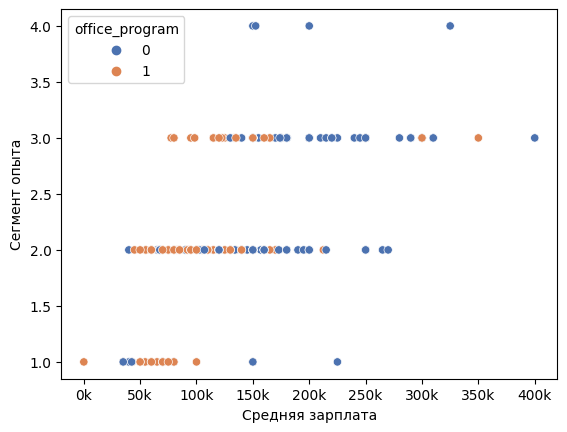

In [267]:

sns.scatterplot(data=df_for_eda, x='salary_middle', y='experience_cat', hue='office_program', palette='deep' ) 
ax1 = plt.gca()

# Set custom axis labels
ax1.set_xlabel("Средняя зарплата")
ax1.set_ylabel("Сегмент опыта")

# форматер
def format_yticks( value, pos):
    return '{:,.0f}k'.format(value /1000)

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))




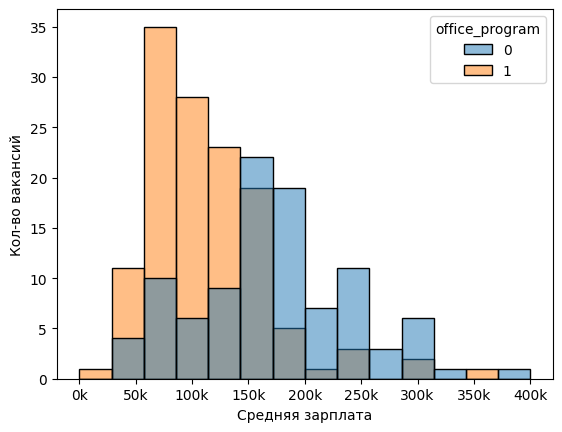

In [253]:
sns.histplot(data=df_for_eda, x='salary_middle', hue='office_program')
ax1 = plt.gca()

# Set custom axis labels
ax1.set_xlabel("Средняя зарплата")
ax1.set_ylabel("Кол-во вакансий")

# форматер
def format_yticks( value, pos):
    return '{:,.0f}k'.format(value /1000)

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(format_yticks))


In [296]:
Markdown( 
df_for_gpt_copy[['business_architecture', 'office_program', 'experience_cat', 'salary_middle','vacancy_name', 'url_description']]\
[ (df_for_gpt_copy.office_program == 0) &\
  (df_for_gpt_copy.business_architecture == 1)&\
  (df_for_gpt_copy.experience_cat == 3) ]\
  .iloc[0]
  .url_description
)

Под новые проекты мы расширяем команду и ищем опытного эксперта
Будет преимуществом опыт работы над ИТ проектами в роли бинес-аналитика в направлениях: финансы, бюджетирование
Функционал:
Сбор, анализ, формализация и согласование бизнес-требований
Анализ текущего состояния бизнес-процессов и подготовка предложений по оптимизации, проектирование и моделирование новых бизнес-процессов, создание схем и описаний процессов
Проработка требований до состояния, когда они понятны консультантам и разработчикам информационных систем, и по ним можно получить оценку трудозатрат на реализацию
Декомпозиция требований на User Story и их приоритизация
Оценка влияния изменений при их внедрении, вовлечение соответствующих экспертов в процессе согласования изменений
Определение показателей оценки эффективности и критерием качества. Выявление и анализ рисков
Координация команд разработки, тестирования и поддержки в ходе реализации задач
Контроль сроков реализации задач и актуализация статусов по задачам
Активное участие в приемке результатов выполненных работ
Наши ожидания:
Опыт работы в направлениях: бизнес-аналитик, системный аналитик от 3 лет
Знание и опыт разработки: карт бизнес-процессов (нотации BPMN, EPC), артефактов (БТ, User Stories, Use Case и пр.), локальных регламентирующих документов
Опыт работы с несколькими стекхолдерами, разного уровня влияния
Опыт взаимодействия с ИТ-подразделениями в части постановки задач и приёмки результатов
Опыт проведение презентаций для технических команд и бизнес подразделений
Опыт проработки процессов от сбора требований до внедрения изменений
Опыт в оценке сроков и трудоёмкости задач
Понимание принципов управленческого и бухгалтерского учета, базовые знания налогового учета
Мы предлагаем:
Постоянный трудовой договор.
Работа в штате Департамента информационных технологий
Официальное оформление в соответствии с ТК РФ, статус официально аккредитованной ИТ компании (бронь и отсрочка, льготная ИТ ипотека)
График работы 5/2, гибкое начало рабочего времени, гибридный график (офис+несколько дней удаленно)
Комфортный офис в районе метро/мцк/мцд Окружная (пешая доступность), гибридный график работы, 2-3 дня в офисе еженедельно
Расширенный полис ДМС
Скидка на продукцию компании
Внутреннее и внешнее обучение
Заинтересованность компании в развитии сотрудников, система мотивации и KPI, годовые бонусы по итогам работы
Спортивные и развлекательные мероприятия, участие в корпоративной жизни компании
ООО «ДМ» представляет бренд ДМТЕХ
Ключевые навыки
BPMN
Бизнес-анализ
MS Visio
Моделирование процессов
IDEF0
Задайте вопрос работодателю
Он получит его с откликом на вакансию
Где располагается место работы?Какой график работы?Вакансия открыта?Какая оплата труда?Как с вами связаться?Другой вопрос

In [271]:
df_for_gpt_copy.head()

,Unnamed: 0.1,Unnamed: 0,vacancy_name,area_id,area_name,published_at,created_at,employer_id,employer_name,employer_link,...,gpt_output_skills,language,domain_knowledge,other,business_architecture,office_program,special_software,coding,visualization,experience_cat
0,0,14175,Ассистент отдела Retail,1,Москва,2024-01-22 09:48:55+03:00,2024-01-22 09:48:55+03:00,4173118,SuperStep,https://hh.ru/employer/4173118,...,"1с; Excel; MS Office (Word, Exсel, Outlook, Po...",0,0,0,0,1,1,0,0,2
1,1,14187,Младший аналитик (IT-компания),1,Москва,2024-01-22 11:46:35+03:00,2024-01-22 11:46:35+03:00,11632,DSM Group,https://hh.ru/employer/11632,...,R;Excel;SQL;VBA;Python;PL-SQL;Oracle;MS SQL,0,0,0,0,1,0,1,0,1
2,2,14195,Специалист по обработке информации,1,Москва,2024-01-22 11:44:21+03:00,2024-01-22 11:44:21+03:00,53797,"ЭФКО, Управляющая компания",https://hh.ru/employer/53797,...,MS Excel,0,0,0,0,1,0,0,0,2
3,3,14231,Аналитик (Правительство Москвы),1,Москва,2024-01-23 09:35:05+03:00,2024-01-23 09:35:05+03:00,4005237,ГКУ города Москвы Московский центр развития со...,https://hh.ru/employer/4005237,...,Excel; Power Point; VBA; power query; формулы ...,0,0,1,0,1,0,1,1,1
4,4,14243,Аналитик товарного ассортимента,1,Москва,2024-01-22 18:38:51+03:00,2024-01-22 18:38:51+03:00,4747616,Абрико,https://hh.ru/employer/4747616,...,1С: Розница;1С: Управление Торговлей;1С: Предп...,0,0,0,0,1,1,0,0,3


In [409]:
df_for_gpt_copy[df_for_gpt_copy.gpt_output_skills.str.contains('nglish') == 1].gpt_output_skills[25]

'MS PowerPoint; MS Excel; Social Media Marketing; Digital Marketing; Marketing Analysis; English language'

In [58]:
s ="aacc"
t ="ccac"




In [63]:
def search(s:list, t:list):
    if len(s) == len(t):
        a = [i for i in s]
        b = [i for i in t]
        a.sort()
        b.sort()
        for j,h in zip(a,b):
            if j!=h:
                return False
        return True
    else:
        return False
        

In [64]:
search(s,t)

False

In [72]:
import collections as cs
 
cs.Counter(s) == cs.Counter(t)


False